# Genetic Algorithm

In [ ]:
!pip install optproblems

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Benchmark functions definition

In [ ]:
from optproblems import cec2005
from optproblems import Individual

import math
import numpy as np
import matplotlib.pyplot as plt
# Defining size of our individuals : in our case, dimensions of the inputs
input_dim = 10
# Choice of the benchmark functions
benchfunct1 = cec2005.F5(input_dim)
benchfunct2 = cec2005.F6(input_dim)
benchfunct3 = cec2005.F9(input_dim)

In [ ]:
# Defining the population size

num_samples = 50 # number of individual in the population
pop_size = (num_samples, input_dim) # shape of our population array

## Fitness Calculation

In [ ]:
def calc_fitness(population, bench_funct):
     # Calculating the fitness value of each individual in the population
     fitness = np.zeros([np.shape(population)[0]])
     for i in range(np.shape(population)[0]):
       res = bench_funct(population[i,:]) # output of the benchmark function
       fitness[i] = -bench_funct(population[i,:]) # We want to minimize so we define the fitness is opposite of the value
        
     return fitness

## Tournament Selection

In [ ]:
import random
def tournament_selection(population, fitness, n_parents, tour_size):

  possible_participant_id = random.randint(0, np.shape(population)[0]-1) # give us an id for a possible participant
  id_selected_participants = np.zeros(tour_size) # store the ID of the selected participants
  selected_participants = np.zeros((tour_size, np.shape(population)[1])) # store the selected participants and their genes
  parents = np.zeros((n_parents, np.shape(population)[1])) # store the parents (winners of each tournament)

  for parent_num in range(n_parents): # to have the desired number of parents
    for i in range(tour_size): # to have the desired number of participants per tournaments
      while possible_participant_id in id_selected_participants: # while the random pick gets an id that is already in the list for the selected participants
        possible_participant_id = random.randint(0, np.shape(population)[0]-1) # we change cause two same samples can't be in the tournament
      
      id_selected_participants[i] = possible_participant_id # if we're here, that means the id we pick is not already in the list so we can pick it
      selected_participants[i] = population[int(id_selected_participants[i])] # then, we add the genes of the participant to the selected participants table
    
    winner_id = get_id_winner_tournament(id_selected_participants, fitness) # Winner id in the population table
    parents[parent_num] = population[int(winner_id)] # Adding to the parent table the genes of the winner

  return parents
      

In [ ]:
def get_id_winner_tournament(participants_id, fitness):
  selected_participants_fitness = [] # list of the fitness of the selected participants
  for id in participants_id:
    selected_participants_fitness.append(fitness[int(id)]) # for each participant ID in the population, we add the fitness of it in this list

  # This gets us the ID of the winner in the selected_participants_fitness list
  winner_index_in_sel_part_fit = selected_participants_fitness.index(max(selected_participants_fitness))
  # This gets us the ID of the winner in the population table
  winner_index_in_population = participants_id[winner_index_in_sel_part_fit]

  return winner_index_in_population


 ## Reproduction between the tournament winners

In [ ]:
import random
def crossover(parents, n_children, crossover_proportion):
     children = np.zeros([n_children, np.shape(parents)[1]])
     # The input number in which we change the parent from which the children takes its genes
     crossover_point = int(crossover_proportion*np.shape(parents)[1])

     for i in range(n_children): # for each future children
      parent1_id = random.randint(0, np.shape(parents)[0]-1) # get a random ID for parent 1
      parent2_id = random.randint(0, np.shape(parents)[0]-1) # get a random ID for parent 2
      while parent1_id == parent2_id: # we can't have a children with the same two parents
        parent2_id = random.randint(0, np.shape(parents)[0]-1) # so we make sure that id2 is different from id1
      
      parent1 = parents[parent1_id] # genes of parent 1
      parent2 = parents[parent2_id] # genes of parent 2

      # first part of the genes of the children comes from parent 1
      children[i, 0:crossover_point] = parent1[0:crossover_point]

      end_point_children = np.shape(children)[1]
      end_point_parent = (np.shape(parent2))[0]
      # second part of the genes of the children comes from parent 2
      children[i, crossover_point:int(end_point_children)] = parent2[crossover_point:end_point_parent]
     return children

## Mutation of the children

In [ ]:
def mutation(children, p_mutation, abs_bound):

  for child in children: # for each child
    for i in range(np.shape(child)[0]): # for each gene
      if random.random() < p_mutation: # with a probability p_mutation
         child[i] += np.random.normal(child[i], 0.3*abs_bound) # the gene takes a random number in a gaussian distribution around the initial value
         if child[i] < -abs_bound: # Keeping the values in the boundaries
           child[i] = -abs_bound
         elif child[i] > abs_bound:
           child[i] = abs_bound

  return children

## Update of the generation by keeping only the best individuals

In [ ]:
def get_new_generation(population, fitness, children, benchfunct):
  # Calculating the fitness of the children
  children_fitness = calc_fitness(children, benchfunct)
  # Creating the global pool with current population + children
  global_pool = np.concatenate((population, children), axis=0)
  global_pool_fitness = np.concatenate((fitness, children_fitness), axis=0)

  # The number to individuals to kill is equal to the number of children, to keep the population size even
  n_samples_to_eliminate = np.shape(children)[0]

  for i in range(n_samples_to_eliminate):
    id_to_eliminate = np.argmin(global_pool_fitness) # taking the individual with the minimum fitness in the global pool
    global_pool[id_to_eliminate,0] = -101 # impossible value in order to recognize the eliminated later
    global_pool_fitness[id_to_eliminate] = max(global_pool_fitness)+1 # making sure that the same individual is not eliminated twice
  
  shift = 0 # shift between the index in population and the index of the adequate equivalent in global_pool
  for i in range(np.shape(population)[0]): # for each place in population
    while global_pool[i+shift, 0] == -101: # if the current individual is one to elimoinate
      shift += 1 # we add 1 to the shift
    population[i] = global_pool[i+shift] # and therefore take the next one in global pool
  
  return population

## Main Loop of Evolution

In [ ]:
# Hyperparameters
n_parents = 20
n_children = 50
crossover_rate = 0.5
mutation_rate = 0.4

In [ ]:
def run_evolution(n_results, n_generations, bench_funct):
  chosen_ones = np.zeros([n_results, input_dim])
  for i in range(n_results):
    print("Simulation n°" + str(i))
    evol_mean_fitness = np.zeros([n_generations]) # evolution of the mean of the fitness
    evol_std_fitness = np.zeros([n_generations]) # evolution of the mean of the fitness
    # Creating the initial population with bounds depending on the benchmark function
    if bench_funct == benchfunct3:
      population = np.random.uniform(low=-5.0, high=5.0, size=pop_size)
    else:
      population = np.random.uniform(low=-100.0, high=100.0, size=pop_size)
    for generation in range(n_generations):

      # Measuring the fitness of each chromosome in the population.
      fitness = calc_fitness(population, bench_funct) # calculating the fitness of the population

      evol_mean_fitness[generation] = np.mean(fitness)
      evol_std_fitness[generation] = np.std(fitness)

      # Selecting the best parents in the population for mating.
      parents = tournament_selection(population, fitness, n_parents, tournament_size) # selecting parents by tournament selection

      # Generating next generation using crossover.
      children = crossover(parents, n_children, crossover_proportion=crossover_rate)

      # Adding some variations to the offsrping using mutation.
      if bench_funct == benchfunct3:
        children = mutation(children, mutation_rate, 5) # adding mutations to the children genes
      else:
        children = mutation(children, mutation_rate, 100)

      # Creating the new population based on the parents and offspring.
      population = get_new_generation(population, fitness, children, bench_funct) # eliminating less fitting individuals to create the new population
     
    # Create a list with the final winners for each evolution simulation
    chosen_ones[i] = get_final_winner(population, fitness, bench_funct)

    # Plot the mean fitness evolution for the last generations
    plt.figure(figsize=(4, 3))
    plt.xlabel('Generation')
    plt.ylabel('Fitness evolution')
    plt.plot(evol_mean_fitness)
    plt.show()
  
  print("Final results :")
  print(chosen_ones)
  print("____________________")
  return chosen_ones

## Evaluation of Results

In [ ]:
def get_final_winner(population, fitness, benchfunct):
  best_final_individual_id = np.argmax(fitness)
  best_final_individual = population[best_final_individual_id]
  print("Best individual : " + str(best_final_individual))
  best_final_individual_result = benchfunct(best_final_individual)
  print("Result of the best individual : " + str(benchfunct(best_final_individual)))
  
  return best_final_individual

In [ ]:
def evaluate_results(results, benchfunct):
  outputs = np.zeros(np.shape(results)[0])
  # Calculating mean values for the results
  for i in range(np.shape(results)[0]):
    print("Function output of the mean results n°" + str(i) + " : " + str(benchfunct(results[i])))
    outputs[i] = benchfunct(results[i])

  mean_output = np.mean(outputs)
  print("Mean of function outputs : " + str(mean_output))

  # Getting the optimal solutions
  opt_sol = benchfunct.get_optimal_solutions()
  opt_output = benchfunct(opt_sol[0].phenome)
  print("Function output of the optimal results : " + str(opt_output))

  print("Optimal results : " + str(opt_sol[0].phenome))

  # Mean of relative errors in the inputs
  mean_mean = 0
  for i in range(np.shape(results)[0]):
    mean_rel_err = 0
    for j in range(input_dim):
      mean_rel_err += abs(opt_sol[0].phenome[j] - results[i, j])/(input_dim*abs(opt_sol[0].phenome[j]))
    print("Mean of the relative errors of the inputs from result n°" + str(i) + " : " + str(mean_rel_err))
    mean_mean += mean_rel_err/input_dim
  print("Mean of the relative errors on all the inputs : " + str(mean_mean))
  

## Run on the 3 benchmark functions

Simulation n°0
Best individual : [-100.         -100.         -100.            8.40365827    7.69456874
   -8.2901071   100.          100.          100.          100.        ]
Result of the best individual : -308.38394802755647


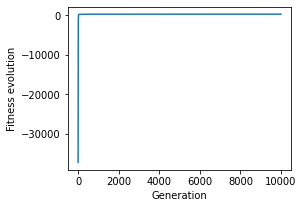

Simulation n°1
Best individual : [-100.         -100.         -100.            8.39765442    7.70239293
   -8.30044022  100.          100.          100.          100.        ]
Result of the best individual : -308.97535050994884


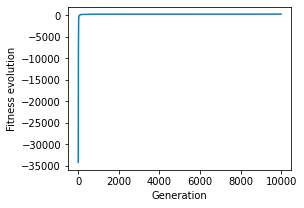

Simulation n°2
Best individual : [-100.         -100.         -100.            8.39017125    7.71793638
   -8.31399632  100.          100.          100.          100.        ]
Result of the best individual : -309.93309189425054


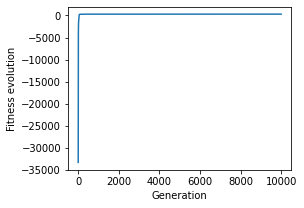

Simulation n°3
Best individual : [-100.         -100.         -100.            8.38873455    7.7215197
   -8.31859473  100.          100.          100.          100.        ]
Result of the best individual : -309.7048304079435


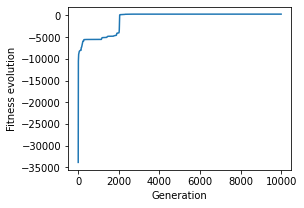

Simulation n°4
Best individual : [-100.         -100.         -100.            8.38968264    7.71803064
   -8.31389813  100.          100.          100.          100.        ]
Result of the best individual : -309.9318301300991


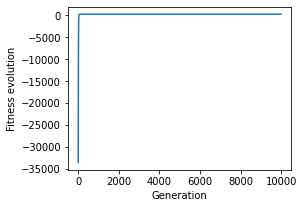

Simulation n°5
Best individual : [-100.         -100.         -100.            8.39908816    7.69609579
   -8.29810164  100.          100.          100.          100.        ]
Result of the best individual : -308.63964603350723


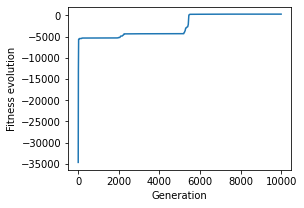

Simulation n°6
Best individual : [-100.         -100.         -100.            8.40503402    7.69825915
   -8.29451202  100.          100.          100.          100.        ]
Result of the best individual : -308.510013984358


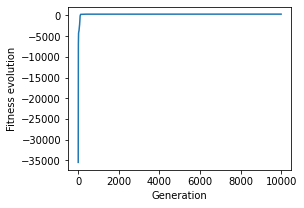

Simulation n°7
Best individual : [-100.         -100.         -100.            8.38040115    7.73113729
   -8.32771131  100.          100.          100.          100.        ]
Result of the best individual : -309.056966707647


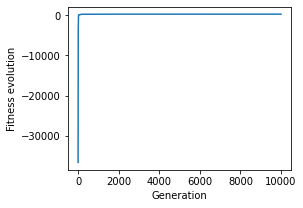

Simulation n°8
Best individual : [-100.         -100.         -100.            8.38750481    7.72170342
   -8.31985614  100.          100.          100.          100.        ]
Result of the best individual : -309.6499594767265


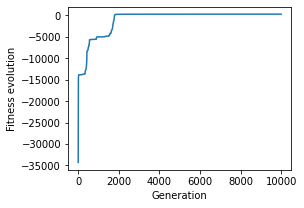

Simulation n°9
Best individual : [-100.         -100.         -100.            8.39056653    7.71870292
   -8.31599002  100.          100.          100.          100.        ]
Result of the best individual : -309.8371605428256


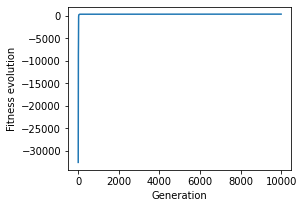

Final results :
[[-100.         -100.         -100.            8.40365827    7.69456874
    -8.2901071   100.          100.          100.          100.        ]
 [-100.         -100.         -100.            8.39765442    7.70239293
    -8.30044022  100.          100.          100.          100.        ]
 [-100.         -100.         -100.            8.39017125    7.71793638
    -8.31399632  100.          100.          100.          100.        ]
 [-100.         -100.         -100.            8.38873455    7.7215197
    -8.31859473  100.          100.          100.          100.        ]
 [-100.         -100.         -100.            8.38968264    7.71803064
    -8.31389813  100.          100.          100.          100.        ]
 [-100.         -100.         -100.            8.39908816    7.69609579
    -8.29810164  100.          100.          100.          100.        ]
 [-100.         -100.         -100.            8.40503402    7.69825915
    -8.29451202  100.          100.        

In [ ]:
evaluate_results(run_evolution(10, 10000, benchfunct1), benchfunct1)

Simulation n°0
Best individual : [  78.87812565  -48.33001736   19.12846253   -2.83008992   69.83503389
   46.36332049   -8.83620765 -100.           67.71420053  100.        ]
Result of the best individual : 2014126.2871791814


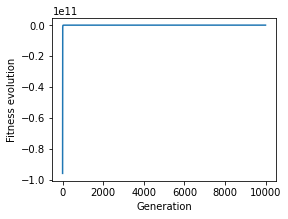

Simulation n°1
Best individual : [ 80.80558267 -48.47901852  19.03730065  -2.80227847  70.09177567
  47.35153192  -7.09740796 -84.29639966  67.13663166 100.        ]
Result of the best individual : 3402.6237058044653


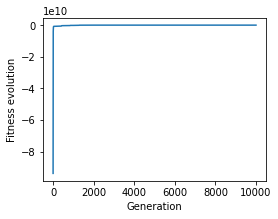

Simulation n°2
Best individual : [ 80.72969861 -48.51235095  19.11676108  -2.71418653  70.00669336
  47.38698481  -7.40746473 -84.77232584  67.89435581 100.        ]
Result of the best individual : 13362.943771001743


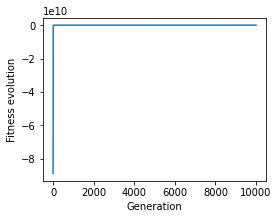

Simulation n°3
Best individual : [ 80.93009036 -49.05953568  18.68177715  -2.87221749  68.71481349
  47.22641485  -7.49892254 -85.81731776  60.17379011   0.14458068]
Result of the best individual : 621.8492936462129


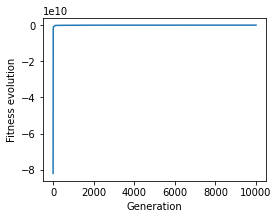

Simulation n°4
Best individual : [ 79.30956204 -48.4070498   19.15482698  -2.74872594  69.95402781
  46.39610251  -8.89567926 -97.1148753   67.55073191 100.        ]
Result of the best individual : 627326.7918616709


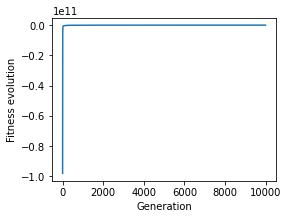

Simulation n°5
Best individual : [ 80.49226985 -49.03885134  18.52777994  -3.19211041  69.72510599
  46.59171157  -7.25262531 -85.19041021  67.38536829 100.        ]
Result of the best individual : 2634.873148101171


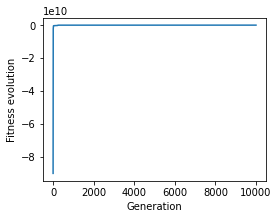

Simulation n°6
Best individual : [ 81.02265374 -48.34710539  19.40005277  -2.36597386  70.4293821
  46.73804532  -8.63413625 -90.32707653  67.32320988 100.        ]
Result of the best individual : 2596.486416247895


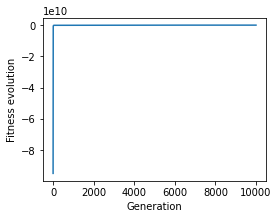

Simulation n°7
Best individual : [ 82.88045449 -47.75278324  19.49102144  -2.68127543  70.56532179
  46.87700195  -8.73911937 -89.77259549  67.35674638 100.        ]
Result of the best individual : 9259.260899652263


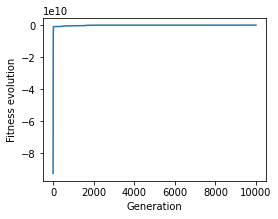

Simulation n°8
Best individual : [  81.42539554  -48.36440888   18.41869968   -3.4604593    69.91245756
   46.39677512   -8.73415739  -88.72651614   56.39388037 -100.        ]
Result of the best individual : 797642.6676453135


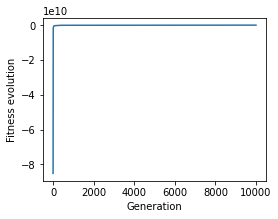

Simulation n°9
Best individual : [ 79.59123415 -49.26983128  18.32560157  -3.40414515  69.15537074
  46.31926338  -8.92836032 -90.9168603   67.2279905   99.65214299]
Result of the best individual : 2461.1378038822236


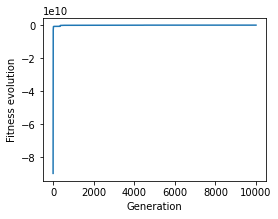

Final results :
[[  78.87812565  -48.33001736   19.12846253   -2.83008992   69.83503389
    46.36332049   -8.83620765 -100.           67.71420053  100.        ]
 [  80.80558267  -48.47901852   19.03730065   -2.80227847   70.09177567
    47.35153192   -7.09740796  -84.29639966   67.13663166  100.        ]
 [  80.72969861  -48.51235095   19.11676108   -2.71418653   70.00669336
    47.38698481   -7.40746473  -84.77232584   67.89435581  100.        ]
 [  80.93009036  -49.05953568   18.68177715   -2.87221749   68.71481349
    47.22641485   -7.49892254  -85.81731776   60.17379011    0.14458068]
 [  79.30956204  -48.4070498    19.15482698   -2.74872594   69.95402781
    46.39610251   -8.89567926  -97.1148753    67.55073191  100.        ]
 [  80.49226985  -49.03885134   18.52777994   -3.19211041   69.72510599
    46.59171157   -7.25262531  -85.19041021   67.38536829  100.        ]
 [  81.02265374  -48.34710539   19.40005277   -2.36597386   70.4293821
    46.73804532   -8.63413625  -90.32707653

In [ ]:
evaluate_results(run_evolution(10, 10000, benchfunct2), benchfunct2)

Simulation n°0
Best individual : [ 1.90079069 -1.563857   -0.97892254 -4.23385925  2.5245238  -4.31009139
  0.97567912 -3.68009645  0.09939579 -3.24603532]
Result of the best individual : -324.66237655464477


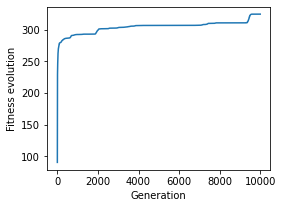

Simulation n°1
Best individual : [ 1.90029435 -1.56776845 -0.98000484 -2.20174992  4.48690467 -4.3501209
  5.         -3.66771536  0.0977649  -3.25380763]
Result of the best individual : -307.2172768824233


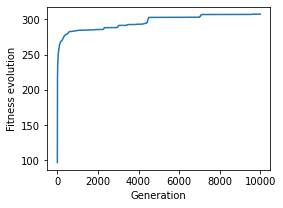

Simulation n°2
Best individual : [ 1.90113132 -1.56429117 -0.97300775 -2.25689733  2.49819367 -4.37718284
  0.97697346 -4.61905759  0.09861024 -4.24823696]
Result of the best individual : -324.83198243893895


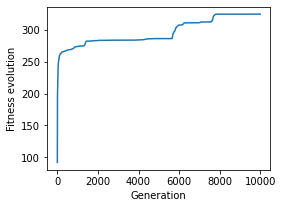

Simulation n°3
Best individual : [ 1.9009282  -1.5660257  -0.97826438 -2.27606318  2.49670332 -3.30898177
  5.         -4.67830369  0.09852848 -4.22240967]
Result of the best individual : -311.35884894994945


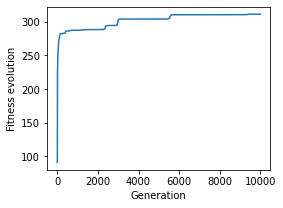

Simulation n°4
Best individual : [ 1.89959585 -1.56513101 -0.97875992 -3.25078157  2.51064361 -4.29457725
  0.97729059 -4.68159299  0.09912996 -5.        ]
Result of the best individual : -314.0073828116627


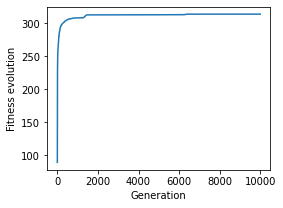

Simulation n°5
Best individual : [ 5.         -1.56407939 -0.97792481 -2.25877433  4.45307786 -5.
  0.97574055 -4.66205189  0.09862644 -4.231631  ]
Result of the best individual : -297.1151274651195


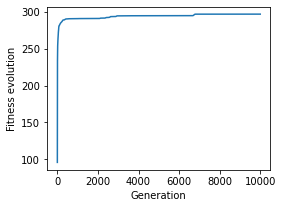

Simulation n°6
Best individual : [ 1.90145019 -1.56496495 -0.98349009 -2.25094127  3.47808614 -4.23372189
  0.97501701 -3.6255018   0.10033856 -3.25549096]
Result of the best individual : -327.1870312328502


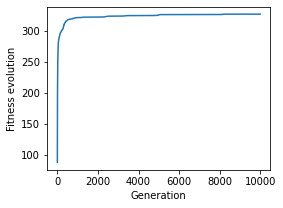

Simulation n°7
Best individual : [ 4.8991642  -1.56526797 -0.97880694 -2.29302338  2.49928526 -4.34721588
  5.         -3.66730273  0.10367562 -4.30967426]
Result of the best individual : -300.60458212829803


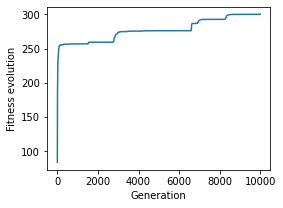

Simulation n°8
Best individual : [ 5.         -1.56418988 -0.97796671 -2.25268315  4.59054079 -3.28059361
  0.97619889 -3.68170802  0.09863622 -4.23125943]
Result of the best individual : -311.4495774949372


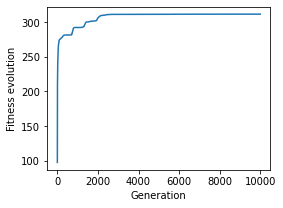

Simulation n°9
Best individual : [ 5.         -1.56230117 -0.97792599 -4.24605116  2.49580071 -3.28811878
  0.97489146 -3.65458977  0.09919453 -4.24454588]
Result of the best individual : -313.49253583586494


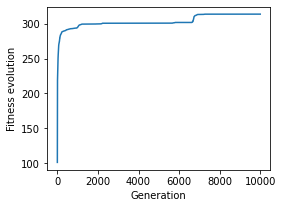

Final results :
[[ 1.90079069 -1.563857   -0.97892254 -4.23385925  2.5245238  -4.31009139
   0.97567912 -3.68009645  0.09939579 -3.24603532]
 [ 1.90029435 -1.56776845 -0.98000484 -2.20174992  4.48690467 -4.3501209
   5.         -3.66771536  0.0977649  -3.25380763]
 [ 1.90113132 -1.56429117 -0.97300775 -2.25689733  2.49819367 -4.37718284
   0.97697346 -4.61905759  0.09861024 -4.24823696]
 [ 1.9009282  -1.5660257  -0.97826438 -2.27606318  2.49670332 -3.30898177
   5.         -4.67830369  0.09852848 -4.22240967]
 [ 1.89959585 -1.56513101 -0.97875992 -3.25078157  2.51064361 -4.29457725
   0.97729059 -4.68159299  0.09912996 -5.        ]
 [ 5.         -1.56407939 -0.97792481 -2.25877433  4.45307786 -5.
   0.97574055 -4.66205189  0.09862644 -4.231631  ]
 [ 1.90145019 -1.56496495 -0.98349009 -2.25094127  3.47808614 -4.23372189
   0.97501701 -3.6255018   0.10033856 -3.25549096]
 [ 4.8991642  -1.56526797 -0.97880694 -2.29302338  2.49928526 -4.34721588
   5.         -3.66730273  0.10367562 -4.309

In [ ]:
evaluate_results(run_evolution(10, 10000, benchfunct3), benchfunct3)